<a href="https://colab.research.google.com/github/ArsheenSingh/Enhancing-CCTV-Systems-with-Two-Factor-Authentication-Using-Voice-and-Face-Recognition/blob/main/Two_Factor_Authentication_FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SpeechRecognition pydub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 50.2 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

!pip install dlib

!pip install face-recognition

!pip install imutils

!pip install scipy

!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=8a8d4bbf058d9b4d4d311701fe73aee6d876df62ed16b981e84b29a9fe684637
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
!pip uninstall -y face-recognition dlib

!pip install dlib==19.18.0

!pip install face-recognition

Found existing installation: face-recognition 1.3.0
Uninstalling face-recognition-1.3.0:
  Successfully uninstalled face-recognition-1.3.0
Found existing installation: dlib 19.24.2
Uninstalling dlib-19.24.2:
  Successfully uninstalled dlib-19.24.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.18.0-cp310-cp310-linux_x86_64.whl size=4329797 sha256=8f3a0bd5ec5ea3d9ff2a69702ee96c194ff321d3b9e61de590d170135e7fc9c0
  Stored in directory: /root/.cache/pip/wheels/20/45/2e/2624ee5964ee28dcf808820f21763650010129242d6e78bf00
Successfully built dlib
  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)


1. Mailgun API Setup and Email Sending Function

This Blocks sets up the Mailgun API, which is used to send emails. It defines an API key, the domain for your Mailgun account, and the owner's email address. The function send_email_with_attachment is responsible for sending an email with an image attachment. This image is captured when an unknown visitor is detected. The function makes a request to Mailgun's API, attaches the image, and sends the email to notify the owner. If the email is sent successfully, it prints a success message; otherwise, it prints an error message.

In [ ]:
import requests

# Mailgun API setup
MAILGUN_API_KEY = '3fa059db07c52e7e18d1cebd81e7bccf-f6fe91d3-b10b41ea'  # Replace with your Mailgun API key
MAILGUN_DOMAIN = 'sandboxb43938edf367403fb9a18b0cb9dbfecd.mailgun.org'  # Replace with your Mailgun domain
OWNER_EMAIL = 'arsheensingh100@gmail.com'  # Replace with the owner's email address

# Email sending function with image attachment
def send_email_with_attachment(image_path, subject="Unknown Visitor Detected"):
    # Mailgun API URL for sending emails
    url = f"https://api.mailgun.net/v3/{MAILGUN_DOMAIN}/messages"

    # Prepare email content
    data = {
        "from": "CCTV System <noreply@yourdomain.com>",  # Change the sender email if needed
        "to": OWNER_EMAIL,
        "subject": subject,
        "text": "An unknown visitor was detected by the CCTV system."
    }

    # Open image and prepare it for attachment
    with open(image_path, "rb") as img_file:
        files = {
            "attachment": img_file
        }

        # Make the POST request to Mailgun's API to send the email
        response = requests.post(
            url,
            auth=("api", MAILGUN_API_KEY),
            data=data,
            files=files
        )

        if response.status_code == 200:
            Email_print="Email sent successfully with attachment!"
            print(Email_print)
        else:
            print(f"Error sending email: {response.status_code} - {response.text}")


2. Face Recognition and Eye-Blink Detection Setup

This block imports libraries that are essential for processing video and performing face recognition. The cv2 (OpenCV) library is used to handle video frames, while the face_recognition library detects and encodes faces from those frames. dlib is used to detect faces and facial landmarks, such as eyes, which are necessary for blink detection. The scipy.spatial.distance module helps measure the distance between different facial landmarks to detect eye blinks. This block also initializes the video capture, using a sample video of CCTV footage, and sets up the necessary detectors and predictors for face detection.

In [ ]:
# 2. Face Recognition and Eye-Blink Detection Setup
import cv2
from google.colab.patches import cv2_imshow
import face_recognition
import dlib
from scipy.spatial import distance
import time

# Load known faces
known_face_encodings = []
known_face_names = []

def load_known_faces(path, name):
    image = face_recognition.load_image_file(path)
    encoding = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(encoding)
    known_face_names.append(name)

# Add known family members' faces
load_known_faces("/content/sarthak photo .jpg", "Family Member 1")
# Add other known faces as needed
#load_known_faces("family_member_2.jpg", "Family Member 2")

# Initialize facial landmarks detector and other necessary objects
detector = dlib.get_frontal_face_detector()
dlib_shape_predictor_path = "/content/shape_predictor_68_face_landmarks.dat"  # Make sure this file is available
predictor = dlib.shape_predictor(dlib_shape_predictor_path)


3. Video Capture and Eye-Blink Detection Parameters

This block defines several variables related to eye blink detection. The eye aspect ratio threshold (eye_aspect_ratio_threshold) is a value that determines when an eye is considered to be blinking. The consecutive frames (eye_aspect_ratio_consec_frames) variable controls how many frames must show a blink for the system to confirm it as a blink. The frame_counter keeps track of how many consecutive frames meet the blink criteria, and the eye_blink_detected variable flags whether a blink has been detected or not.

In [ ]:
# 3. Video Capture and Eye-Blink Detection Parameters
# Video capture initialization
video_capture = cv2.VideoCapture("/content/sarthakvideo.mp4")  # Replace with your video path

# Eye-blink detection parameters
eye_aspect_ratio_threshold = 0.2
eye_aspect_ratio_consec_frames = 3
frame_counter = 0
eye_blink_detected = False

# Function to calculate eye aspect ratio
def calculate_eye_aspect_ratio(eye_points):
    A = distance.euclidean((eye_points[1].x, eye_points[1].y), (eye_points[5].x, eye_points[5].y))
    B = distance.euclidean((eye_points[2].x, eye_points[2].y), (eye_points[4].x, eye_points[4].y))
    C = distance.euclidean((eye_points[0].x, eye_points[0].y), (eye_points[3].x, eye_points[3].y))
    return (A + B) / (2.0 * C)


4. Timestamp and Frame Capture

This function calculates the Eye Aspect Ratio (EAR), which is a ratio of distances between key points around the eye. When the eye is open, the EAR will have a higher value, and when the eye blinks, the EAR drops. The function computes the distances between various points around the eye (using the facial landmarks detected by dlib) and returns the EAR. If the EAR is below a certain threshold, it indicates a blink.


In [ ]:
def add_timestamp_to_frame(frame):
    font = cv2.FONT_HERSHEY_SIMPLEX
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S")  # Get the current timestamp
    text_y_position = 80  # Adjust Y-position for the timestamp
    cv2.putText(frame, timestamp, (10, text_y_position), font, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
    return frame


5. Main Loop for Face Detection and Blink Detection

This is the main part of the program where the video frames are processed in a loop. It first reads each frame from the video file. If a frame is successfully captured, it is converted to RGB format for face detection. The program then checks if any faces are detected. If a face is recognized, it compares the detected face with known faces (stored in known_face_encodings) and checks if the person is a match. If the person is recognized, it calculates the eye aspect ratio to detect blinks. If a blink is detected, the system grants access to the person and adds the frame to a list of captured frames. If the person is not recognized (unknown visitor), it captures the frame and sends an email to notify the owner, using the send_email_with_attachment function.

In [ ]:
# 5. Main Loop for Face Detection and Blink Detection
unknown_visitor_detected = False
captured_frames = []

# Main loop to process video frames
while True:
    ret, frame = video_capture.read()
    if not ret:
        print("Error: Failed to read a frame from the video.")
        break

    rgb_frame = frame[:, :, ::-1]  # Convert frame from BGR to RGB
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    for face_encoding, face_location in zip(face_encodings, face_locations):
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        if True in matches:
            first_match_index = matches.index(True)
            name = known_face_names[first_match_index]

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 0)

            for rect in rects:
                shape = predictor(gray, rect)
                left_eye = [shape.part(i) for i in range(36, 42)]
                right_eye = [shape.part(i) for i in range(42, 48)]

                left_ear = calculate_eye_aspect_ratio(left_eye)
                right_ear = calculate_eye_aspect_ratio(right_eye)
                ear = (left_ear + right_ear) / 2.0

                if ear < eye_aspect_ratio_threshold:
                    frame_counter += 1
                else:
                    if frame_counter >= eye_aspect_ratio_consec_frames:
                        eye_blink_detected = True
                    frame_counter = 0

                if eye_blink_detected:
                    print(f"Face Recognized and Blink Detected! Recognizing Speech...")

                    for point in left_eye + right_eye:
                        cv2.circle(frame, (point.x, point.y), 2, (0, 255, 0), -1)
                    cv2.putText(frame, "Blink Detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    frame = add_timestamp_to_frame(frame)

                    captured_frames.append(frame)
                    if len(captured_frames) >= 3:  # Capture 3 frames after blink detection
                        break

        else:
            # If an unknown visitor is detected, capture image and send email
            if not unknown_visitor_detected:
                print("Unknown visitor detected, sending notification...")
                cv2.imwrite("/content/unknown_visitor.jpg", frame)  # Save the captured frame
                send_email_with_attachment("/content/unknown_visitor.jpg")  # Send email with attachment
                unknown_visitor_detected = True
                break

    if eye_blink_detected or len(captured_frames) >= 3 or unknown_visitor_detected:
        break  # Stop processing after either condition is met


Face Recognized and Blink Detected! Recognizing Speech...


6.Speech Recognition

This code implements voice password verification for access control. If an eye-blink is detected, it triggers the audio verification step. The `audio_to_text` function transcribes the provided audio file using Google’s Speech Recognition API, and the recognized text is compared to a predefined password. If the text matches the password, access is granted; otherwise, access is denied. If no eye-blink is detected, the system assumes an unknown person is attempting access and sends an email notification to alert the user.

In [ ]:
if eye_blink_detected:
  import os
  import numpy as np
  import speech_recognition as sr
  from pydub import AudioSegment

# Step 3: Define Constants
  PASSWORD = "hello open"  # Set your password here

# Function to convert audio to text
  def audio_to_text(audio_file):
      recognizer = sr.Recognizer()
      with sr.AudioFile(audio_file) as source:
          audio_data = recognizer.record(source)
      try:
        # Recognize speech using Google Web Speech API
          text = recognizer.recognize_google(audio_data)
          return text.lower()  # Convert to lowercase for comparison
      except sr.UnknownValueError:
          print("Could not understand audio")
          return None
      except sr.RequestError as e:
          print(f"Could not request results from Google Speech Recognition service; {e}")
          return None

# Function to check access
  def check_access(audio_file):
      recognized_text = audio_to_text(audio_file)
      if recognized_text is not None:
          print(f"Recognized Text: {recognized_text}")
          if recognized_text == PASSWORD:
              print("Face Recognized,Blink Detected,Speech Recognized->Access Granted!")
          else:
              print("Access Denied!")
      else:
          print("No valid speech recognized.")


# Assuming the uploaded file is named 'test_audio.wav'
  test_audio_file = '/content/WhatsApp Audio 2024-11-08 at 3.57.43 PM.wav'  # Change this if your file has a different name

# Step 5: Check Access with the provided audio file
  check_access(test_audio_file)
else:
  print("Unkown Person Detected!,Email Sent!")

Recognized Text: hello open
Face Recognized,Blink Detected,Speech Recognized->Access Granted!


7. Final Steps: Display and Save Captured Frames

After processing the video, the frames where a blink was detected are saved as images. These frames are then displayed using cv2_imshow, allowing the user to see the results. Finally, the program releases the video capture object and closes all OpenCV windows, cleaning up the resources used during the execution.




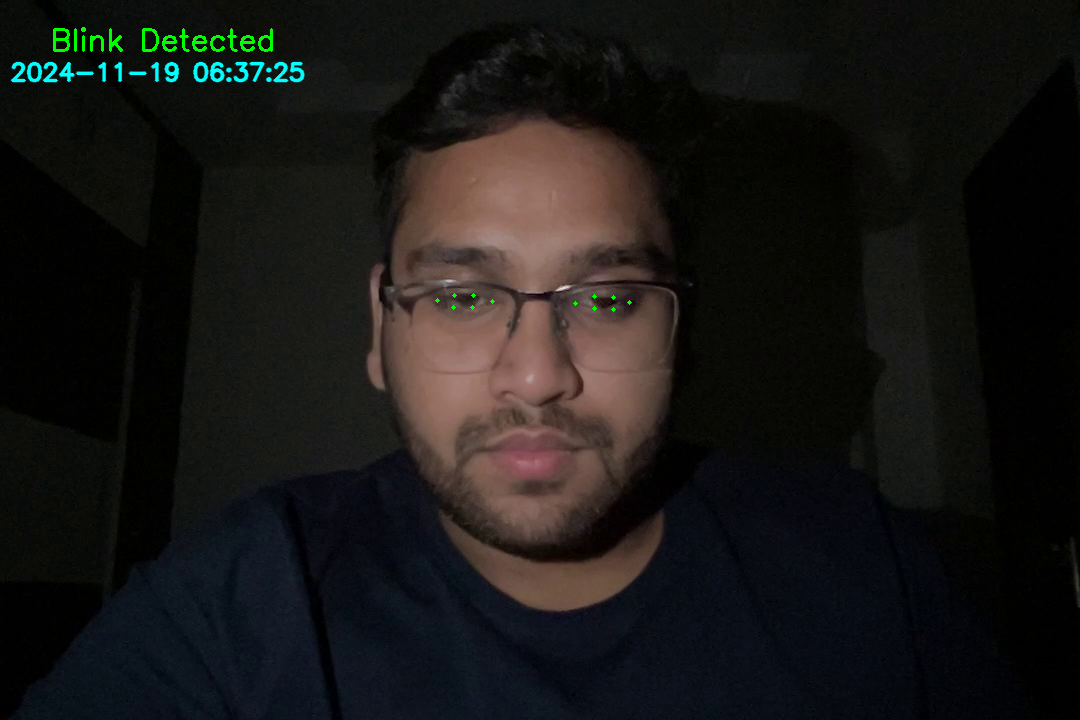

In [ ]:
# 6. Final Steps: Display and Save Captured Frames
# Process and display captured frames (optional)
for idx, captured_frame in enumerate(captured_frames):
    cv2.imwrite(f"/content/blink_frame_{idx}.jpg", captured_frame)  # Save captured frames
    cv2_imshow(captured_frame)  # Display captured frames in Colab

# Release video capture and close windows
video_capture.release()
cv2.destroyAllWindows()
